# Gesture Recognition

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
from matplotlib import pyplot as plt
import cv2

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
data_directory = "/datasets/Project_data"

In [4]:
train_doc = np.random.permutation(open(f"{data_directory}/train.csv").readlines())
val_doc = np.random.permutation(open(f"{data_directory}/val.csv").readlines())
train_path = os.path.join(data_directory, "train")
val_path = os.path.join(data_directory, "val")
print(f"train_path = {train_path}\nval_path = {val_path}")

train_path = /datasets/Project_data/train
val_path = /datasets/Project_data/val


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
class DataGenerator:
    def __init__(self, width=120, height=120, channels=3, batch_size=30,
                num_epochs=30, augment_types=[], frames=30, start_index=0,
                        increment=1):
        self.width = width
        self.height = height
        self.channels = channels
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.augment_types = augment_types
        self.num_classes = 5
        self.frames = frames
        self.start_index = start_index
        self.increment = increment
    
    def generator(self, source_path, folder_list):
        print(f"\nSource path = {source_path}; batch size = {self.batch_size}")
        img_idx = np.arange(self.start_index, self.frames, self.increment).tolist()
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches =len(t)//self.batch_size
            for batch in range(num_batches):
                batch_data, batch_labels= self.single_batch(source_path, t, batch, batch_size, img_idx)
                yield batch_data, batch_labels
            
            remaining_seq=len(t)%batch_size
            if not remaining_seq:
                batch_data, batch_labels= self.single_batch(source_path, t, num_batches, batch_size, img_idx, remaining_seq)
                yield batch_data, batch_labels 
                
    def single_batch(self, source_path, t, batch, batch_size, img_idx, remaining_seq=0):
        sequence_len = remaining_seq if remaining_seq else batch_size
        
        batch_data = np.zeros((sequence_len, len(img_idx), self.height, self.width, self.channels))
        batch_labels = np.zeros((sequence_len, self.num_classes))
        
        if "affine" in self.augment_types:
            batch_data_affine = np.zeros((sequence_len, len(img_idx), self.height, self.width, self.channels))
            batch_labels_affine = np.zeros((sequence_len, self.num_classes))
        
        for folder in range(sequence_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                # read image from source path
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                # Resize image to desired dimensions
                resize_img = resize(image, (self.height, self.width, 3))
                # Rescale image
                batch_data[folder,idx,:,:,0] = (resize_img[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (resize_img[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (resize_img[:,:,2])/255
                
                if "affine" in self.augment_types:
                    rows, cols, ch = resize_img.shape
                    input_pts = np.float32([[0,0], [cols-1,0], [0,rows-1]])
                    output_pts = np.float32([[cols-1,0], [0,0], [cols-1,rows-1]])
                    M = cv2.getAffineTransform(input_pts , output_pts)
                    batch_data_affine[folder, idx] = cv2.warpAffine(resize_img, M, (resize_img.shape[0], resize_img.shape[1]))
                
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if "affine" in self.augment_types:
                batch_labels_affine[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        if "affine" in self.augment_types:
            batch_data = np.append(batch_data, batch_data_affine, axis = 0) 
            batch_labels = np.append(batch_labels, batch_labels_affine, axis = 0)
        return (batch_data, batch_labels)

        
        
        
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential, initializers
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

# input_shape = (30, 120, 120, 3)

class Conv3DModelGenerator:
    def __init__(self, input_shape=(30, 120, 120, 3), 
                 kernel_size=(3,3,3), pool_size=(2,2,2), dropouts=0.0,
                num_classes=5, num_hidden_layers=3, optimizer=Adam(), 
                 conv_layer=1, normalise=False, metrics=["categorical_accuracy"]):
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropouts = dropouts
        self.num_classes = num_classes
        self.num_hidden_layers = num_hidden_layers
        self.optimizer = optimizer
        self.conv_layer = conv_layer
        self.normalise = normalise
        self.metrics = metrics
        
    def conv3d(self):
        print(f"Self : {self.input_shape}")
        model = Sequential()
        model.add(Conv3D(16, kernel_size=self.kernel_size,
                         input_shape=self.input_shape, 
                         padding="same",
                         activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=self.pool_size))
        neuron_num = 32
        for val in range(self.num_hidden_layers):
            self.add_3d_layer(model, neuron_num)
            neuron_num = 2 * neuron_num
            
        self.add_flatten_layer(model)
        return model
            
    def add_flatten_layer(self, model, num_dense_layer=1):
        num_neuron = 64
        model.add(Flatten())
        for layer in range(num_dense_layer):
            model.add(Dense(num_neuron, activation="relu"))
            model.add(Dropout(self.dropouts))
            
        model.add(Dense(self.num_classes, activation="softmax"))
            
    def add_3d_layer(self, model, neuron_num=32):
        for layer in range(self.conv_layer):
            model.add(Conv3D(neuron_num, 
                             kernel_size=self.kernel_size,
                             padding="same", 
                             activation="relu"))
        
        if self.normalise:
            model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=self.pool_size))
        
    def add_compiler(self, model):
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=self.metrics)
        print (model.summary())

In [7]:
def train(model, data_generator, num_epochs, batch_size):
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    num_epochs = num_epochs
    print ('# epochs =', num_epochs)

    train_generator = data_generator.generator(train_path, train_doc)
    val_generator = data_generator.generator(val_path, val_doc)

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                 save_best_only=False, save_weights_only=False, 
                                 mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=2, cooldown=1, verbose=1)
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

In [8]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [9]:
batch_size = 30
num_epochs = 20
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs)


In [10]:
model_gen = Conv3DModelGenerator(normalise=True)
model = model_gen.conv3d()
model_gen.add_compiler(model)

Self : (30, 120, 120, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (N

In [11]:
history = train(model=model, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20
Instructions for updating:
Please use Model.fit, which supports generators.

Source path = /datasets/Project_data/train; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.8312 - categorical_accuracy: 0.4275
Source path = /datasets/Project_data/val; batch size = 30

Epoch 00001: saving model to model_init_2021-08-0117_21_29.066589/model-00001-2.83122-0.42754-2.44482-0.27500.h5
23/23 [==============================] - 122s 5s/step - loss: 2.8312 - categorical_accuracy: 0.4275 - val_loss: 2.4448 - val_categorical_accuracy: 0.2750
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.9426 - categorical_accuracy: 0.5826
Epoch 00002: saving model to model_init_2021-08-0117_21_29.066589/model-00002-0.94257-0.58261-1.93009-0.35833.h5
23/23 [==============================] - 127s 6s/step - loss: 0.9426 - categorical_accuracy: 0.5826 - val_loss: 1.9301 - val_categorical_accur

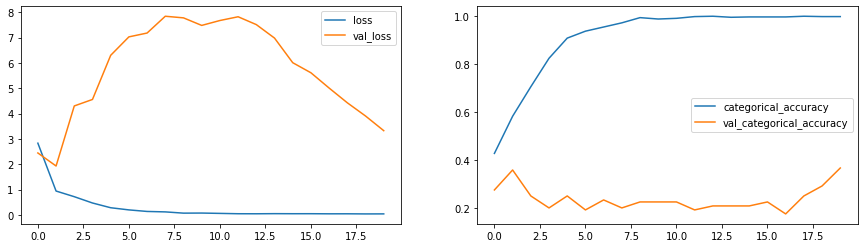

In [12]:
plot(history)

### Model 2: Add dropouts since model is overfitting

Self : (20, 120, 120, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 60, 60, 32)    27680     
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 

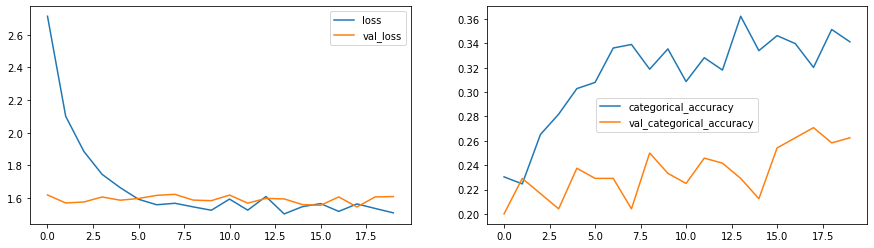

In [13]:
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs, augment_types=["affine"], start_index=10)
model_gen_drop = Conv3DModelGenerator(normalise=True, dropouts=0.2, conv_layer=2, input_shape=(20, 120, 120, 3))
model_drop = model_gen_drop.conv3d()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs)
plot(history_drop)

### Model 3:  Change input dimension

Self : (20, 100, 100, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 50, 50, 32)    27680     
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 

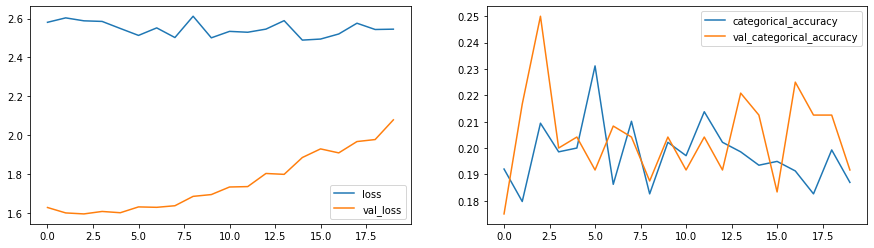

In [14]:
width = 100
height = 100
input_shape=(20, width, height, 3)
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs, augment_types=["affine"], start_index=10, width=width, height=height)
model_gen_drop = Conv3DModelGenerator(normalise=True, dropouts=0.2, conv_layer=2, input_shape=input_shape)
model_drop = model_gen_drop.conv3d()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs)
plot(history_drop)

### Model 4: Increase the number of layers

Self : (20, 120, 120, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 20, 60, 60, 16)    0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 20, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 60, 60, 32)    128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 20, 30, 30, 32)    0         
_________________________________________________________________
conv3d_20 (Conv3D)           

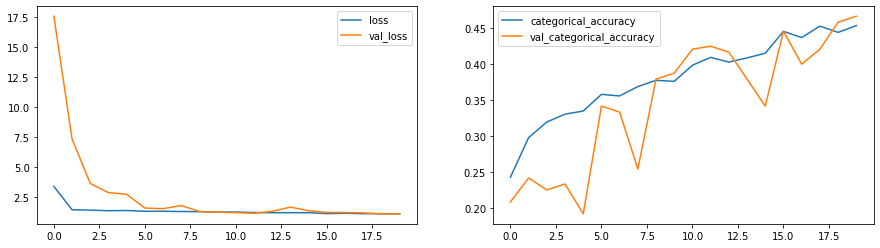

In [15]:
width = 120
height = 120
# num_epochs_model4 = 30
input_shape=(20, width, height, 3)
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=True)
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs, augment_types=["affine"], start_index=10, width=width, height=height)
model_gen_drop = Conv3DModelGenerator(normalise=True, dropouts=0.4, input_shape=input_shape, pool_size=(1, 2, 2), num_hidden_layers=5, optimizer=optimizer)
model_drop = model_gen_drop.conv3d()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs)
plot(history_drop)

### More hidden layers

Self : (14, 80, 80, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 14, 80, 80, 16)    1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 40, 40, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 40, 40, 32)    13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 40, 40, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 20, 20, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (Non

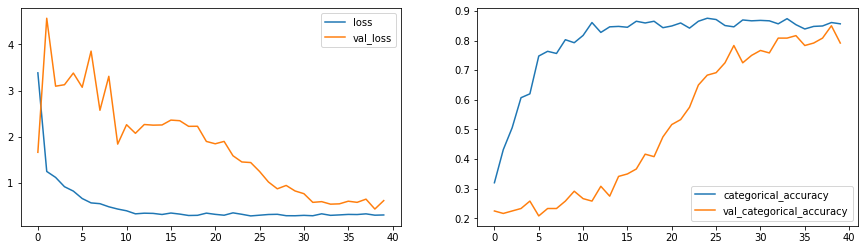

In [10]:
width = 80
height = 80
num_epochs_model4 = 40
input_shape=(14, width, height, 3)
frames=25
start_index=11
optimizer = Adam()
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height, start_index=start_index, frames=frames)
model_gen_drop = Conv3DModelGenerator(normalise=True, dropouts=0.25, input_shape=input_shape, num_hidden_layers=4, pool_size=(1, 2, 2), optimizer=optimizer)
model_drop = model_gen_drop.conv3d()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)

### Validation score of above model : 83.33%

### Model with dimension 160 * 160

Self : (17, 160, 160, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 17, 160, 160, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 17, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 17, 80, 80, 32)    13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 80, 80, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 40, 40, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (N

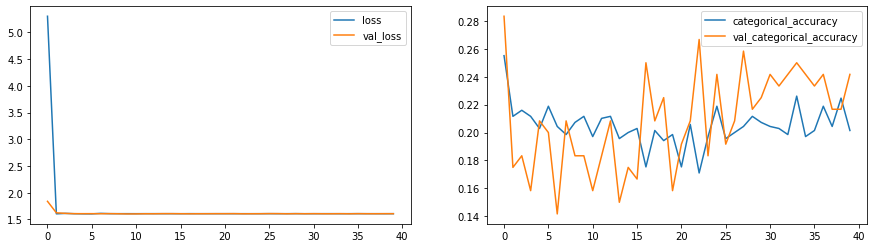

In [19]:
width = 160
height = 160
num_epochs_model4 = 40
input_shape=(17, width, height, 3)
frames=28
start_index=11
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height, start_index=start_index, frames=frames)
model_gen_drop = Conv3DModelGenerator(normalise=True, dropouts=0.25, input_shape=input_shape, num_hidden_layers=6, pool_size=(1, 2, 2))
model_drop = model_gen_drop.conv3d()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)

In [11]:
class Conv2dRNNModelGenerator:
    def __init__(self, input_shape=(30, 120, 120, 3), rnn_type="GRU", num_rnn_layers=1,
                 kernel_size=(3,3), pool_size=(2,2), dropouts=0.0,
                 num_classes=5, num_hidden_layers=2, optimizer=Adam(), 
                 conv_layer=1, normalise=False, metrics=["categorical_accuracy"]):
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropouts = dropouts
        self.num_classes = num_classes
        self.num_hidden_layers = num_hidden_layers
        self.optimizer = optimizer
        self.conv_layer = conv_layer
        self.normalise = normalise
        self.metrics = metrics
        self.rnn_type = rnn_type
        self.num_rnn_layers = num_rnn_layers
        
    def conv2d_rnn(self):
        model = Sequential()
        self.conv2d(model)
        self.rnn(model)
        return model
    
    def conv2d(self, model):
        print(f"self.input_shape : {self.input_shape}")
        model.add(TimeDistributed(Conv2D(16, kernel_size=self.kernel_size, 
                         padding="same",
                         activation="relu"), input_shape=self.input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=self.pool_size)))
        neuron_num = 32
        for val in range(self.num_hidden_layers):
            model.add(TimeDistributed(Conv2D(neuron_num, kernel_size=self.kernel_size,
                                            padding="same",
                                            activation="relu")))
            if self.normalise:
                model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(MaxPooling2D(pool_size=self.pool_size)))
            neuron_num = 2*neuron_num
        model.add(TimeDistributed(Flatten()))
        
    def rnn(self, model):
        weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
        if self.rnn_type == "GRU":
            for layer in range(self.num_rnn_layers):
                model.add(GRU(128, 
                        activation=None,
                        kernel_initializer=weights,
                        dropout = self.dropouts))
        else:
            for layer in range(self.num_rnn_layers):
                model.add(LSTM(128, 
                        activation=None,
                        kernel_initializer=weights,
                        dropout = self.dropouts))
                
        model.add(Dropout(self.dropouts))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(self.dropouts))
        model.add(Dense(self.num_classes, activation='softmax'))
        
    def add_compiler(self, model):
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=self.metrics)
        print (model.summary())
        
        

In [21]:
data_gen_cnn_rnn = DataGenerator(batch_size=batch_size)
cnn_rnn_model_gen = Conv2dRNNModelGenerator(normalise=True)
cnn_rnn_model = cnn_rnn_model_gen.conv2d_rnn()
cnn_rnn_model_gen.add_compiler(cnn_rnn_model)

self.input_shape : (30, 120, 120, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_

In [22]:
history = train(model=cnn_rnn_model, 
      data_generator=data_gen_cnn_rnn,
      batch_size=batch_size,
      num_epochs=num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20

Source path = /datasets/Project_data/train; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 7.8773 - categorical_accuracy: 0.3609
Source path = /datasets/Project_data/val; batch size = 30

Epoch 00001: saving model to model_init_2021-08-0205_22_50.338952/model-00001-7.87728-0.36087-3.67116-0.25833.h5
23/23 [==============================] - 118s 5s/step - loss: 7.8773 - categorical_accuracy: 0.3609 - val_loss: 3.6712 - val_categorical_accuracy: 0.2583
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.8698 - categorical_accuracy: 0.6841
Epoch 00002: saving model to model_init_2021-08-0205_22_50.338952/model-00002-1.86984-0.68406-6.07870-0.20833.h5
23/23 [==============================] - 119s 5s/step - loss: 1.8698 - categorical_accuracy: 0.6841 - val_loss: 6.0787 - val_categorical_accuracy: 0.2083
Epoch 3/20
23/23 [==============================] - ETA: 0s - lo

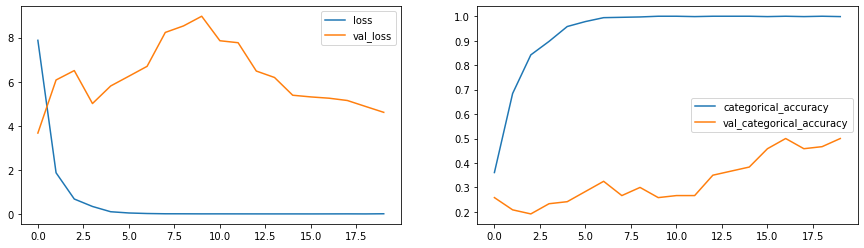

In [24]:
plot(history)

### Model 2 for CNN_RNN

self.input_shape : (30, 120, 120, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_

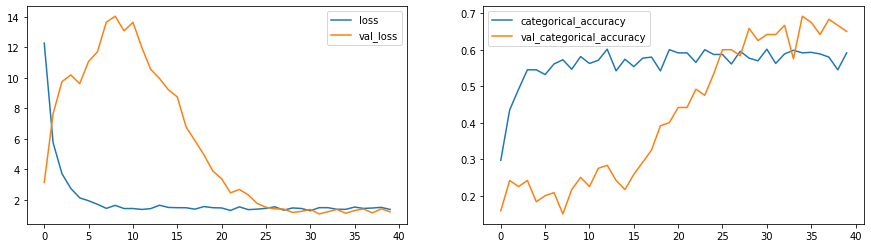

In [25]:
width = 120
height = 120
num_epochs_model4 = 40
input_shape=(30, width, height, 3)
optimizer = Adam()
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height)
model_gen_drop = Conv2dRNNModelGenerator(normalise=True, dropouts=0.25, input_shape=input_shape, num_hidden_layers=3, pool_size=(2, 2), optimizer=optimizer)
model_drop = model_gen_drop.conv2d_rnn()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)

self.input_shape : (17, 120, 120, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 17, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 17, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_25 (TimeDis (None, 17, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 17, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 17, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 17, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_

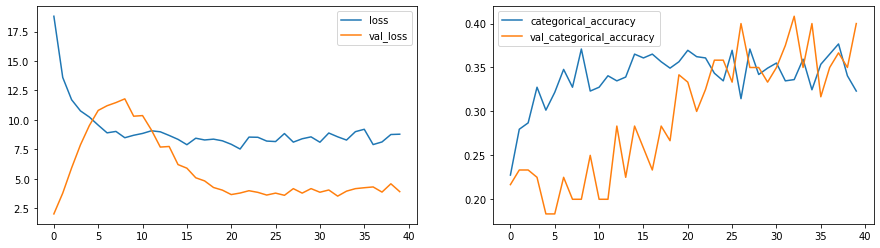

In [26]:
width = 120
height = 120
num_epochs_model4 = 40
input_shape=(17, width, height, 3)
frames=28
start_index=11
optimizer = Adam(0.0001)
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height, start_index=start_index, frames=frames)
model_gen_drop = Conv2dRNNModelGenerator(normalise=True, dropouts=0.3, input_shape=input_shape, num_hidden_layers=3, pool_size=(2, 2), optimizer=optimizer)
model_drop = model_gen_drop.conv2d_rnn()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)

self.input_shape : (17, 120, 120, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 17, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 17, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 17, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 17, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 

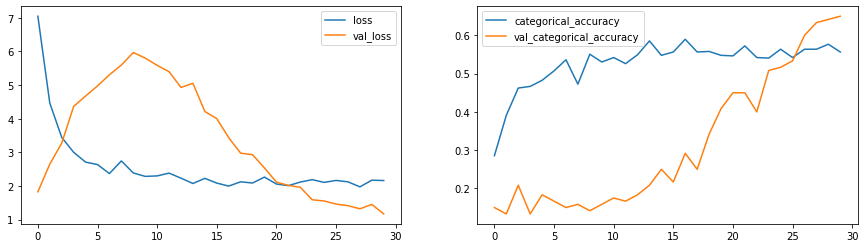

In [12]:
width = 120
height = 120
num_epochs_model4 = 30
input_shape=(17, width, height, 3)
frames=28
start_index=11
optimizer = Adam(0.0001)
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height, start_index=start_index, frames=frames)
model_gen_drop = Conv2dRNNModelGenerator(normalise=True, dropouts=0.25, input_shape=input_shape, num_hidden_layers=4, pool_size=(2, 2), optimizer=optimizer)
model_drop = model_gen_drop.conv2d_rnn()
model_gen_drop.add_compiler(model_drop)
history_drop = train(model=model_drop, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)

### Using transfer learning

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [14]:
def build_mobilenet(shape=(224, 224, 3), trainable = 0,nbout=3):
    model = MobileNetV2(
        include_top=False,
        input_shape=shape,
        weights="imagenet")
    # Keep 9 layers to train﻿﻿
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return Sequential([model, output])

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 1280)          2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 1280)          0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 1280)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               541440    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________

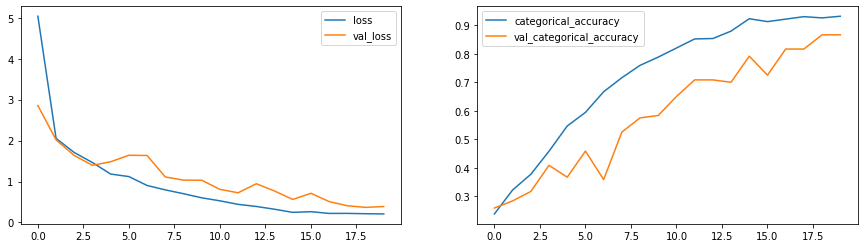

In [15]:
width = 224
height = 224
num_epochs_model4 = 20
input_shape=(15, width, height, 3)
frames=28
start_index=13
optimizer = Adam(0.001)
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height, start_index=start_index, frames=frames)
convnet = build_mobilenet(input_shape[1:], trainable = 15)
model = Sequential()
model.add(TimeDistributed(convnet, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(TimeDistributed(Flatten()))
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
model.add(GRU(128, 
            activation="relu",
            kernel_initializer=weights,
            dropout = 0.2))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["categorical_accuracy"])
print (model.summary())
history_drop = train(model=model, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 17, 1280)          2257984   
_________________________________________________________________
dropout_5 (Dropout)          (None, 17, 1280)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 17, 1280)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               541440    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

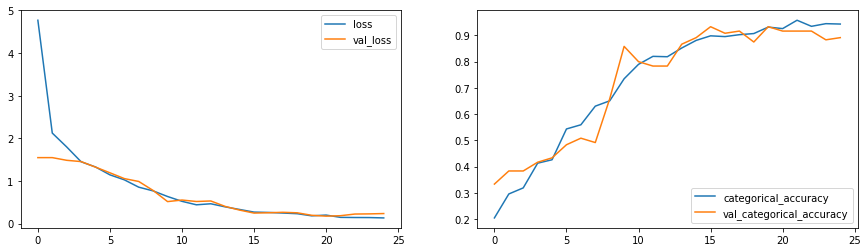

In [16]:
width = 224
height = 224
num_epochs_model4 = 25
input_shape=(17, width, height, 3)
frames=28
start_index=11
optimizer = Adam(0.001)
data_gen = DataGenerator(batch_size=batch_size, num_epochs=num_epochs_model4, width=width, height=height, start_index=start_index, frames=frames)
convnet = build_mobilenet(input_shape[1:], trainable = 15)
model = Sequential()
model.add(TimeDistributed(convnet, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(TimeDistributed(Flatten()))
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
model.add(GRU(128, 
            activation="relu",
            kernel_initializer=weights,
            dropout = 0.2))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["categorical_accuracy"])
print (model.summary())
history_drop = train(model=model, 
      data_generator=data_gen,
      batch_size=batch_size,
      num_epochs=num_epochs_model4)
plot(history_drop)